In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pylab
import scipy.stats as stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, average_precision_score, f1_score, auc, precision_recall_curve, recall_score, precision_score
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install scikit_fuzzy
import skfuzzy as fuzz
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout
!pip install pdpbox
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
data = pd.read_csv('BO_Training_Dataset.csv')

print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print("Number of categorical featues including Product id and target variable : " , data.select_dtypes(exclude=['int', 'float']).shape[1])
print('Features : ', data.columns.values)

Number of data points :  1048575
Number of features :  23
Number of categorical featues including Product id and target variable :  7
Features :  ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


In [ ]:
data.drop(['sku'], axis = 1,inplace=True)

In [7]:
# Label encoding categorical variables
cat = data.select_dtypes(include = ['object']).columns
for col in cat:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [9]:
# Lst of columns having right skewed data
skewed_right = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month',
                'forecast_9_month' , 'sales_1_month','sales_3_month',
                'sales_6_month','sales_9_month' ,
                'min_bank','pieces_past_due','local_bo_qty']

In [10]:
# Train and test split
from sklearn.model_selection import train_test_split

data_y = data['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(data.drop(['went_on_backorder'], axis=1), data_y , random_state = 42 , stratify=data_y,test_size=0.20)


In [11]:
# Selecting the column indices which are right skewed to apply log transform
log_columns = []

for i in skewed_right:
    log_columns.append(X_train.columns.get_loc(i))

In [12]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)
Xtrain = imp.transform(X_train)
Xtest = imp.transform(X_test)

In [13]:
def log_transform(a):
    sign = np.sign(a[log_columns])
    a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign
    return a

In [14]:
X_train_log = np.apply_along_axis(log_transform, 1, Xtrain)
X_test_log = np.apply_along_axis(log_transform, 1, Xtest)

## **Dummy classifier**

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_log, y_train)


DummyClassifier(strategy='uniform')

## **Balanced bagging with random forest estimator (BRFC)**

In [16]:
bb =BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_log, y_train)

## **Fuzy parameters**

In [ ]:
fuzzy_params = {
    'national_inv': [0, 10, 100],
    'lead_time': [0, 2, 10],
    'in_transit_qty': [0, 5, 100],
    'forecast_3_month': [0, 10, 100],
    'forecast_6_month': [0, 10, 100],
    'forecast_9_month': [0, 10, 100],
    'sales_1_month': [0, 10, 100],
    'sales_3_month': [0, 10, 100],
    'sales_6_month': [0, 10, 100],
    'sales_9_month': [0, 10, 100],
    'min_bank': [0, 10, 100],
    'potential_issue': [0, 0.5, 1],
    'pieces_past_due': [0, 5, 50],
    'perf_6_month_avg': [0, 0.5, 1],
    'perf_12_month_avg': [0, 0.5, 1],
    'local_bo_qty': [0, 5, 50],
    'deck_risk': [0, 0.5, 1],
    'oe_constraint': [0, 0.5, 1],
    'ppap_risk': [0, 0.5, 1],
    'stop_auto_buy': [0, 0.5, 1],
    'rev_stop': [0, 0.5, 1]
}

# Apply fuzzy logic inference to each column based on the defined fuzzy parameters
def apply_fuzzy_logic(data, fuzzy_params):
    fuzzy_inputs = []
    for i, (column, params) in enumerate(fuzzy_params.items()):
        fuzzy_membership = fuzz.trimf(data[:, i], params)
        fuzzy_inputs.append(fuzzy_membership)
    fuzzy_inputs_2D = [fuzzy_membership.reshape(-1, 1) for fuzzy_membership in fuzzy_inputs]
    return np.concatenate(fuzzy_inputs_2D, axis=1)

# Apply fuzzy logic to the test data
X_train_fuzzy = apply_fuzzy_logic(X_train_log, fuzzy_params)

# Fit a Balanced Bagging with fuzzy logic
bb_fuzzy = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_fuzzy, y_train)

## **VAE + BRFC**

In [24]:
# autoencoder architecture
input_dim = X_train_log.shape[1]
latent_dim = 13

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

vae = Model(input_layer, decoded)

# Compile the autoencoder
vae.compile(optimizer='adam', loss='mse')

# Train the autoencoder
vae.fit(X_train_log, X_train_log, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

# Use the trained VAE to encode the input data
encoder = Model(input_layer, encoded)
encoded_X_train = encoder.predict(X_train_log)

# Combine the latent representations with the original features
combined_X_train = np.concatenate([X_train_log, encoded_X_train], axis=1)

# Fit Balanced Bagging with autoencoder
bb_autoencoder = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1).fit(combined_X_train, y_train)

Epoch 1/10
10486/10486 [==============================] - 29s 3ms/step - loss: 0.0929 - val_loss: 0.0125
Epoch 2/10
10486/10486 [==============================] - 35s 3ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 3/10
10486/10486 [==============================] - 47s 4ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 4/10
10486/10486 [==============================] - 26s 3ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 5/10
10486/10486 [==============================] - 26s 2ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 6/10
10486/10486 [==============================] - 26s 2ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 7/10
10486/10486 [==============================] - 26s 2ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 8/10
10486/10486 [==============================] - 26s 2ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 9/10
10486/10486 [==============================] - 26s 2ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 10/10
26215/26215 [==============================

In [25]:
# Encode the test data using the trained autoencoder
encoded_X_test = encoder.predict(X_test_log)

# Combine the encoded representations with the original features for the test data
combined_X_test = np.concatenate([X_test_log, encoded_X_test], axis=1)


6554/6554 [==============================] - 10s 1ms/step


## **MLP**

In [ ]:
# MLP architecture
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the MLP model
mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the MLP model
mlp_model.fit(X_train_log, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20972/20972 [==============================] - 55s 2ms/step - loss: 0.0344 - accuracy: 0.9915 - val_loss: 0.0326 - val_accuracy: 0.9914
Epoch 2/10
20972/20972 [==============================] - 55s 3ms/step - loss: 0.0330 - accuracy: 0.9915 - val_loss: 0.0333 - val_accuracy: 0.9914
Epoch 3/10
20972/20972 [==============================] - 54s 3ms/step - loss: 0.0328 - accuracy: 0.9915 - val_loss: 0.0328 - val_accuracy: 0.9914
Epoch 4/10
20972/20972 [==============================] - 55s 3ms/step - loss: 0.0327 - accuracy: 0.9915 - val_loss: 0.0328 - val_accuracy: 0.9913
Epoch 5/10
20972/20972 [==============================] - 56s 3ms/step - loss: 0.0327 - accuracy: 0.9915 - val_loss: 0.0326 - val_accuracy: 0.9914
Epoch 6/10
20972/20972 [==============================] - 51s 2ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0.0330 - val_accuracy: 0.9913
Epoch 7/10
20972/20972 [==============================] - 56s 3ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0

## **predictions for the test data**

In [ ]:
dummy_preds_proba = dummy_clf.predict_proba(X_test_log)[:,1]
bb_preds_proba = bb.predict_proba(X_test_log)[:, 1]
bb_fuzzy_preds_proba = bb_fuzzy.predict_proba(X_test_log)[:, 1]
bb_autoencoder_preds_proba = bb_autoencoder.predict_proba(combined_X_test)[:, 1]
mlp_preds_proba = mlp_model.predict(X_test_log)

# ROC curves
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_preds_proba)
fpr_bb, tpr_bb, _ = roc_curve(y_test, bb_preds_proba)
fpr_bb_fuzzy, tpr_bb_fuzzy, _ = roc_curve(y_test, bb_fuzzy_preds_proba)
fpr_bb_autoencoder, tpr_bb_autoencoder, _ = roc_curve(y_test, bb_autoencoder_preds_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds_proba)

# AUC scores
auc_dummy = auc(fpr_dummy, tpr_dummy)
auc_bb = auc(fpr_bb, tpr_bb)
auc_bb_fuzzy = auc(fpr_bb_fuzzy, tpr_bb_fuzzy)
auc_bb_autoencoder = auc(fpr_bb_autoencoder, tpr_bb_autoencoder)
auc_mlp = auc(fpr_mlp, tpr_mlp)

6554/6554 [==============================] - 9s 1ms/step


## **ROC-AUC, PR-AUC plots**

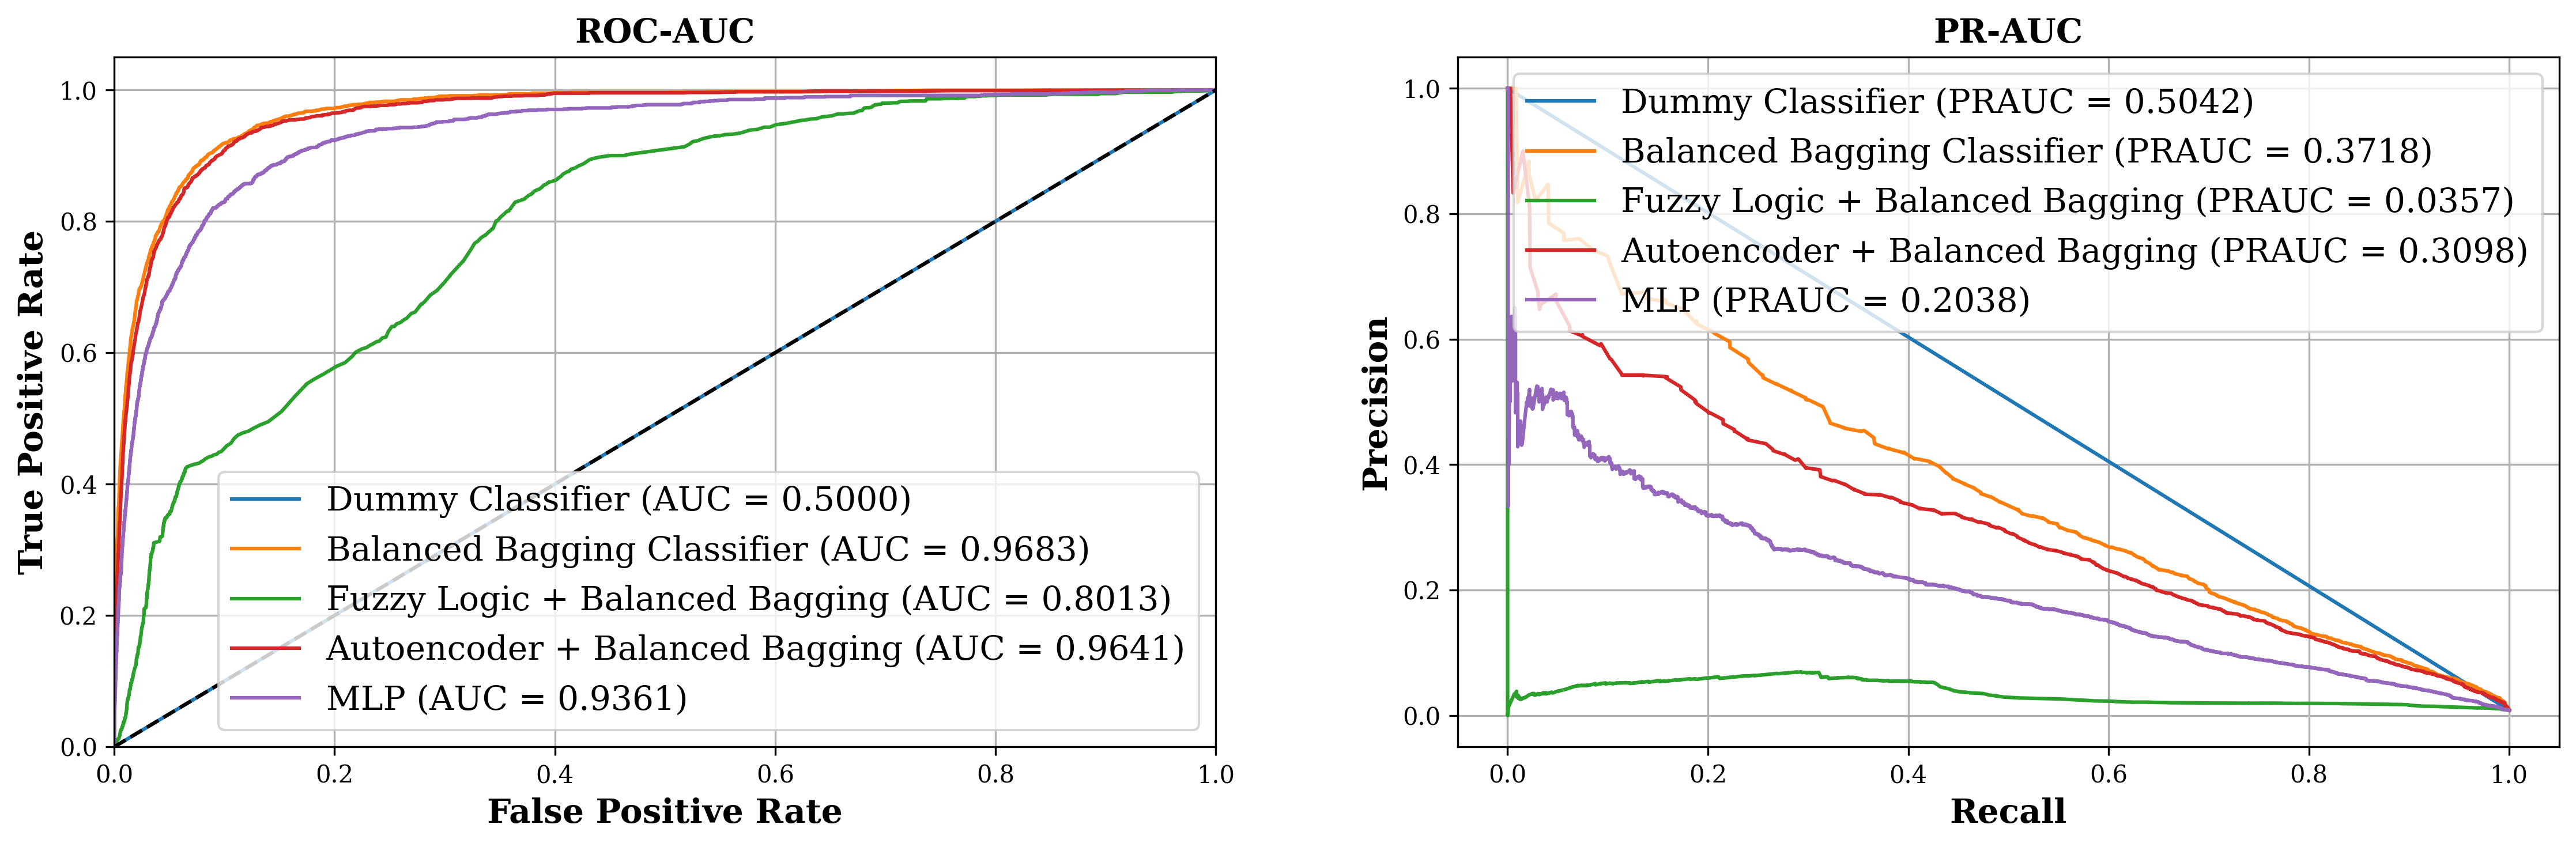

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

# Plot ROC curves
axes[0].plot(fpr_dummy, tpr_dummy, label=f'Dummy Classifier (AUC = {auc_dummy:.4f})')
axes[0].plot(fpr_bb, tpr_bb, label=f'Balanced Bagging Classifier (AUC = {auc_bb:.4f})')
axes[0].plot(fpr_bb_fuzzy, tpr_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (AUC = {auc_bb_fuzzy:.4f})')
axes[0].plot(fpr_bb_autoencoder, tpr_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (AUC = {auc_bb_autoencoder:.4f})')
axes[0].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=14)
axes[0].set_title('ROC-AUC', fontsize=14, fontweight='bold')
axes[0].grid()

from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curves
preauc_dummy, recall_dummy, _ = precision_recall_curve(y_test, dummy_preds_proba)
auc_dummy = auc(recall_dummy, preauc_dummy)
preauc_bb, recall_bb, _ = precision_recall_curve(y_test, bb_preds_proba)
auc_bb = auc(recall_bb, preauc_bb)
preauc_bb_fuzzy, recall_bb_fuzzy, _ = precision_recall_curve(y_test, bb_fuzzy_preds_proba)
auc_fuzzy = auc(recall_bb_fuzzy, preauc_bb_fuzzy)
preauc_bb_autoencoder, recall_bb_autoencoder, _ = precision_recall_curve(y_test, bb_autoencoder_preds_proba)
auc_bbauto = auc(recall_bb_autoencoder, preauc_bb_autoencoder)
preauc_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_preds_proba)
auc_mlp = auc(recall_mlp, preauc_mlp)

# Plot Precision-Recall curves
axes[1].plot(recall_dummy, preauc_dummy, label=f'Dummy Classifier (PRAUC = {auc_dummy:.4f})')
axes[1].plot(recall_bb, preauc_bb, label=f'Balanced Bagging Classifier (PRAUC = {auc_bb:.4f})')
axes[1].plot(recall_bb_fuzzy, preauc_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (PRAUC = {auc_fuzzy:.4f})')
axes[1].plot(recall_bb_autoencoder, preauc_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (PRAUC = {auc_bbauto:.4f})')
axes[1].plot(recall_mlp, preauc_mlp, label=f'MLP (PRAUC = {auc_mlp:.4f})')
axes[1].set_xlabel('Recall', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=14)
axes[1].set_title('PR-AUC', fontsize=14, fontweight='bold')
axes[1].grid()

plt.tight_layout()
plt.show()


In [ ]:
# # Get predictions for the test data
bb_preds_proba = bb.predict_proba(X_test_log)[:, 1]
bb_autoencoder_preds_proba = bb_autoencoder.predict_proba(combined_X_test)[:, 1]
# # Calculate ROC curves
fpr_bb, tpr_bb, _ = roc_curve(y_test, bb_preds_proba)
fpr_bb_autoencoder, tpr_bb_autoencoder, _ = roc_curve(y_test, bb_autoencoder_preds_proba)

# Calculate AUC scores
auc_bb = auc(fpr_bb, tpr_bb)
auc_bb_autoencoder = auc(fpr_bb_autoencoder, tpr_bb_autoencoder)

## **ROC AUc and PRAUC on predictions (BRFC & VAE-BRFC)**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

bb_pred = bb.predict(X_test_log)
y_pred_binary_bb = (bb_pred > 0.5).astype(int)
# confusion matrix
cm_bb = confusion_matrix(y_test, y_pred_binary_bb)
bb_autoencoder_pred = bb_autoencoder.predict(combined_X_test)
y_pred_binary_autoencoder = (bb_autoencoder_pred > 0.5).astype(int)
# confusion matrix
cm_bb_autoencoder = confusion_matrix(y_test, y_pred_binary_autoencoder)

# precision, recall, and thresholds for the precision-recall curve
precision_bb, recall_bb, thresholds_pr_bb = precision_recall_curve(y_test, bb_pred)

# Calculate false positive rate, true positive rate, and thresholds for the ROC curve
fpr_bb, tpr_bb, thresholds_roc_bb = roc_curve(y_test, bb_pred)
roc_auc_bb = auc(fpr_bb, tpr_bb)

# Calculate PRAUC score
pr_auc_bb = auc(recall_bb, precision_bb)
# print("PRAUC Score:", pr_auc)

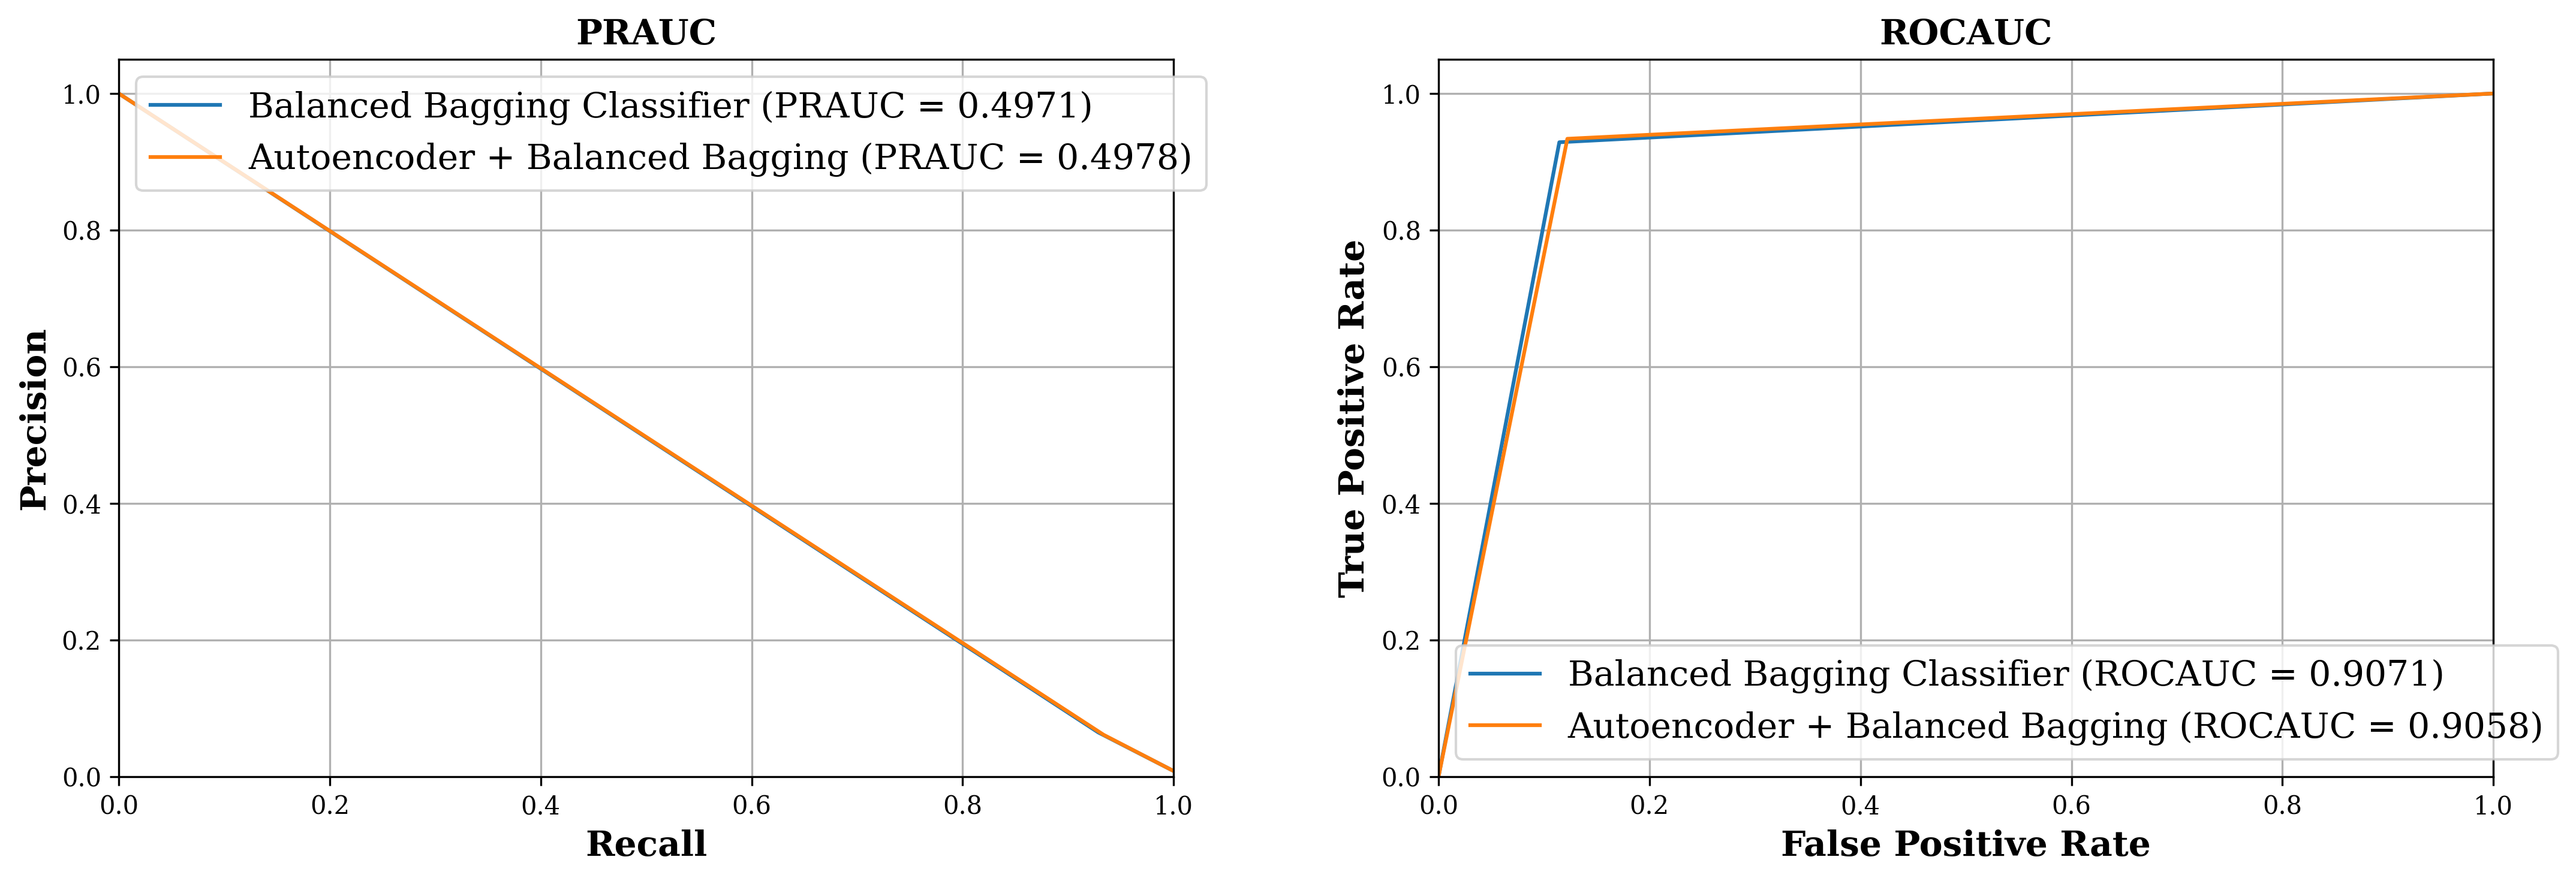

In [ ]:
# Calculate precision, recall, and thresholds for the precision-recall curve
precision_autoencoder, recall_autoencoder, thresholds_pr_auencoder = precision_recall_curve(y_test, bb_autoencoder_pred)

# Calculate false positive rate, true positive rate, and thresholds for the ROC curve
fpr_autoencoder, tpr_autoencoder, thresholds_roc_autoencoder = roc_curve(y_test, bb_autoencoder_pred)
roc_auc_autoencoder = auc(fpr_autoencoder, tpr_autoencoder)

# Calculate PRAUC score
pr_auc_autoencoder = auc(recall_autoencoder, precision_autoencoder)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

# Plot precision-recall curve for Balanced Bagging Classifier
axes[0].plot(recall_bb, precision_bb, label='Balanced Bagging Classifier (PRAUC = %0.4f)' % pr_auc_bb)
axes[0].set_title("PRAUC", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Recall", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Precision", fontsize=14, fontweight='bold')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].grid(True)
axes[0].legend(loc="best", fontsize=14)

# Plot precision-recall curve for Autoencoder + Balanced Bagging
axes[0].plot(recall_autoencoder, precision_autoencoder, label='Autoencoder + Balanced Bagging (PRAUC = %0.4f)' % pr_auc_autoencoder)
axes[0].set_title("PRAUC", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Recall", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Precision", fontsize=14, fontweight='bold')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].grid(True)
axes[0].legend(loc="best", fontsize=14)

# Plot ROC curve for Balanced Bagging Classifier
axes[1].plot(fpr_bb, tpr_bb, label='Balanced Bagging Classifier (ROCAUC = %0.4f)' % roc_auc_bb)
axes[1].set_title("ROCAUC", fontsize=14, fontweight='bold')
axes[1].set_xlabel("False Positive Rate", fontsize=14, fontweight='bold')
axes[1].set_ylabel("True Positive Rate", fontsize=14, fontweight='bold')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].grid(True)
axes[1].legend(loc="best", fontsize=14)

# Plot ROC curve for Autoencoder + Balanced Bagging
axes[1].plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder + Balanced Bagging (ROCAUC = %0.4f)' % roc_auc_autoencoder)
axes[1].set_title("ROCAUC", fontsize=14, fontweight='bold')
axes[1].set_xlabel("False Positive Rate", fontsize=14, fontweight='bold')
axes[1].set_ylabel("True Positive Rate", fontsize=14, fontweight='bold')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].grid(True)
axes[1].legend(loc="best", fontsize=14)

plt.tight_layout()
plt.show()

## **Threshold setting for BRFC and VAE-BRFC**

In [ ]:
from sklearn.metrics import f1_score

# precision, recall, and corresponding threshold for the model
precision_autoencoder, recall_autoencoder, threshold_autoencoder = precision_recall_curve(y_test, bb_autoencoder_preds_proba)
precision_balanced_bagging, recall_balanced_bagging, threshold_balanced_bagging = precision_recall_curve(y_test, bb_preds_proba)

# define thresholds
thresholds_autoencoder = threshold_autoencoder[:-1]
thresholds_balanced_bagging = threshold_balanced_bagging[:-1]

# evaluate F1 score for each threshold
f1_scores_autoencoder = [f1_score(y_test, (bb_autoencoder_preds_proba >= t).astype(int)) for t in thresholds_autoencoder]
f1_scores_balanced_bagging = [f1_score(y_test, (bb_preds_proba >= t).astype(int)) for t in thresholds_balanced_bagging]

# get best threshold for each model
best_threshold_autoencoder = thresholds_autoencoder[np.argmax(f1_scores_autoencoder)]
best_threshold_balanced_bagging = thresholds_balanced_bagging[np.argmax(f1_scores_balanced_bagging)]

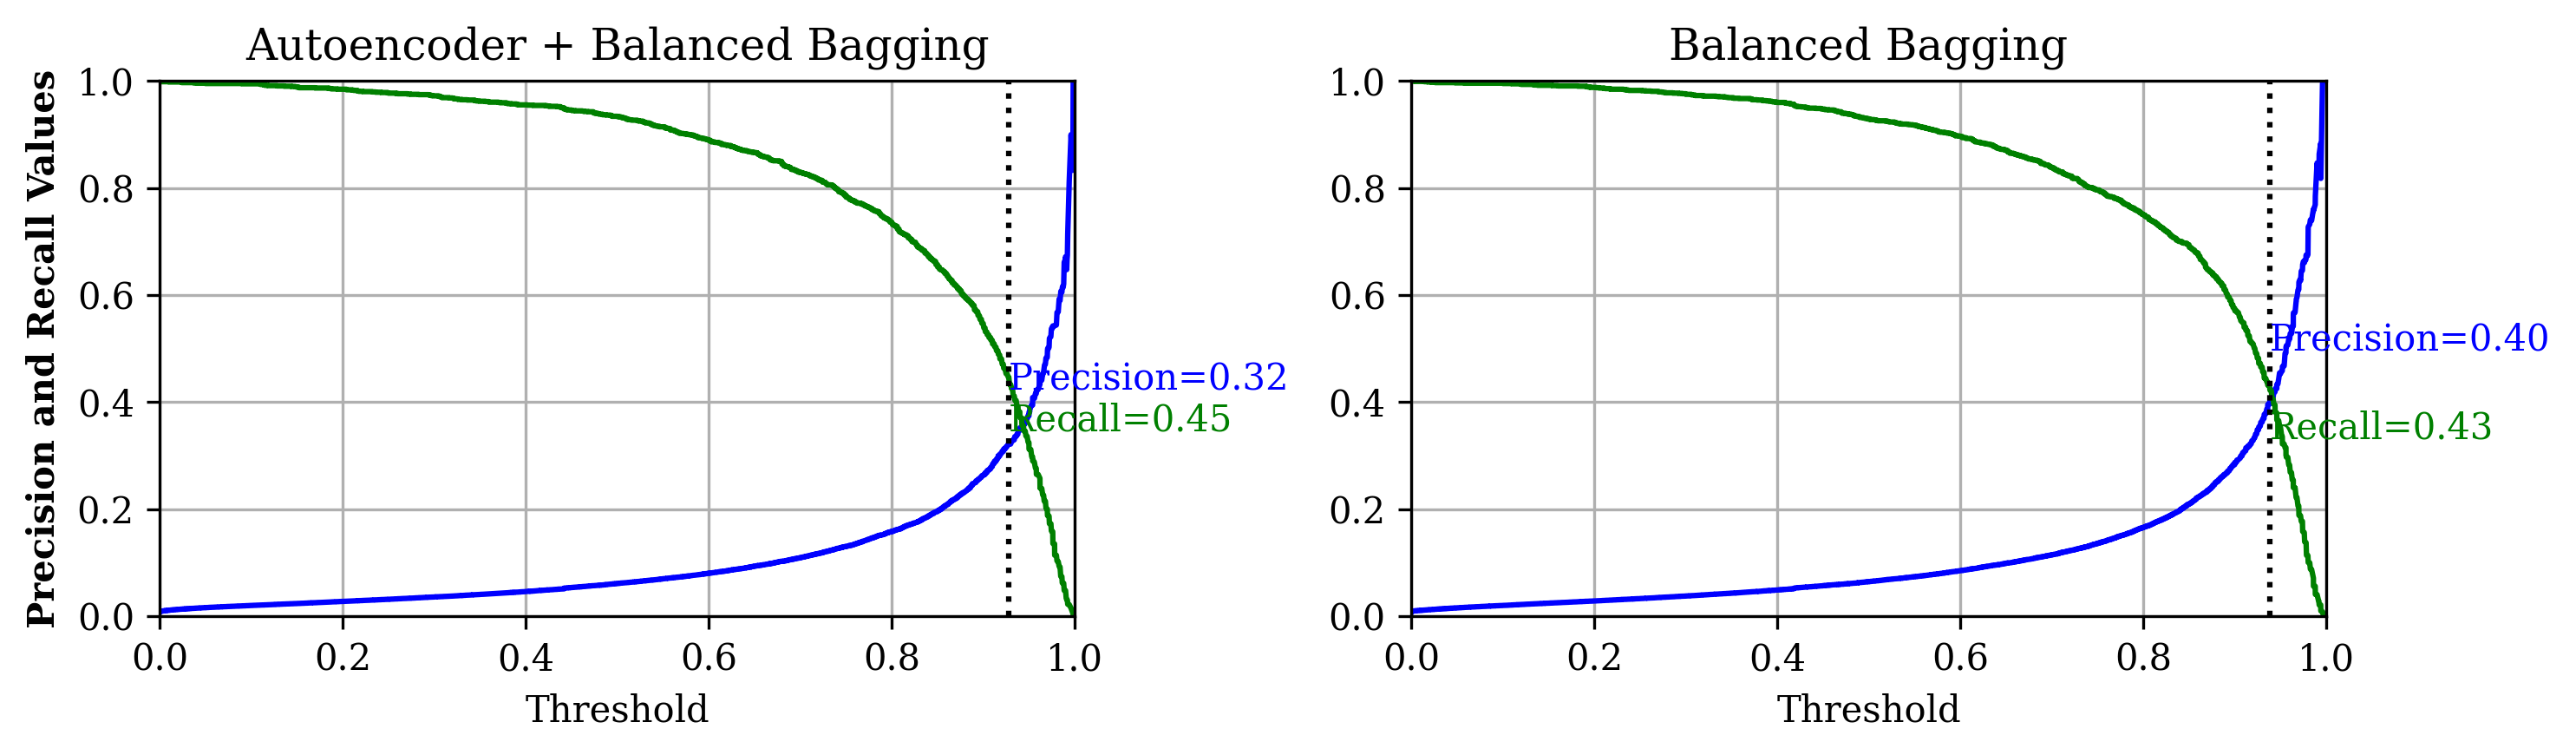

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3), dpi=300)  # Set the figure size

# Plot Precision and Recall for Autoencoder + Balanced Bagging (Left plot)
plt.subplot(1, 2, 1)  # Create the left subplot
plt.plot(threshold_autoencoder, precision_autoencoder[:-1], 'blue', label='Precision (Autoencoder + Balanced Bagging)')
plt.plot(threshold_autoencoder, recall_autoencoder[:-1], 'green', label='Recall (Autoencoder + Balanced Bagging)')
plt.axvline(x=best_threshold_autoencoder, linestyle=":", color='k')  # Vertical line at the best threshold
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision and Recall Values', fontweight='bold')
plt.xlabel('Threshold')
plt.title('Autoencoder + Balanced Bagging')
plt.grid()

# Annotate the plot with precision and recall values for Autoencoder + Balanced Bagging
threshold_display_autoencoder = best_threshold_autoencoder  # Threshold for which precision and recall are displayed
index_autoencoder = np.argmin(np.abs(threshold_autoencoder - threshold_display_autoencoder))  # Find the index of the threshold closest to the desired threshold
plt.text(threshold_autoencoder[index_autoencoder], precision_autoencoder[index_autoencoder] + 0.1, f'Precision={precision_autoencoder[index_autoencoder]:.2f}', fontsize=10, color='blue')
plt.text(threshold_autoencoder[index_autoencoder], recall_autoencoder[index_autoencoder] - 0.1, f'Recall={recall_autoencoder[index_autoencoder]:.2f}', fontsize=10, color='green')


# Plot Precision and Recall for Balanced Bagging (Right plot)
plt.subplot(1, 2, 2)  # Create the right subplot
plt.plot(threshold_balanced_bagging, precision_balanced_bagging[:-1], 'blue', label='Precision (Balanced Bagging)')
plt.plot(threshold_balanced_bagging, recall_balanced_bagging[:-1], 'green', label='Recall (Balanced Bagging)')
plt.axvline(x=best_threshold_balanced_bagging, linestyle=":", color='k')  # Vertical line at the best threshold
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.title('Balanced Bagging')
plt.grid()

# Annotate the plot with precision and recall values for Balanced Bagging
threshold_display_balanced_bagging = best_threshold_balanced_bagging  # Threshold for which precision and recall are displayed
index_balanced_bagging = np.argmin(np.abs(threshold_balanced_bagging - threshold_display_balanced_bagging))  # Find the index of the threshold closest to the desired threshold
plt.text(threshold_balanced_bagging[index_balanced_bagging], precision_balanced_bagging[index_balanced_bagging] + 0.1, f'Precision={precision_balanced_bagging[index_balanced_bagging]:.2f}', fontsize=10, color='blue')
plt.text(threshold_balanced_bagging[index_balanced_bagging], recall_balanced_bagging[index_balanced_bagging] - 0.1, f'Recall={recall_balanced_bagging[index_balanced_bagging]:.2f}', fontsize=10, color='green')

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Show the plot



## **Calibration with sigmoid**

In [26]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrate BRFC
calibrated_bb = CalibratedClassifierCV(bb, method='sigmoid', cv='prefit').fit(X_train_log, y_train)

# Calibrate VAE+BRFC
calibrated_bb_autoencoder = CalibratedClassifierCV(bb_autoencoder, method='sigmoid', cv='prefit').fit(combined_X_train, y_train)

# Get predictions for the test data after calibration
calibrated_bb_preds_proba = calibrated_bb.predict_proba(X_test_log)[:, 1]
calibrated_bb_autoencoder_preds_proba = calibrated_bb_autoencoder.predict_proba(combined_X_test)[:, 1]

# Calculate reliability curve
prob_true_bb, prob_pred_bb = calibration_curve(y_test, calibrated_bb_preds_proba, n_bins=10, strategy='uniform')
prob_true_bb_autoencoder, prob_pred_bb_autoencoder = calibration_curve(y_test, calibrated_bb_autoencoder_preds_proba, n_bins=10, strategy='uniform')

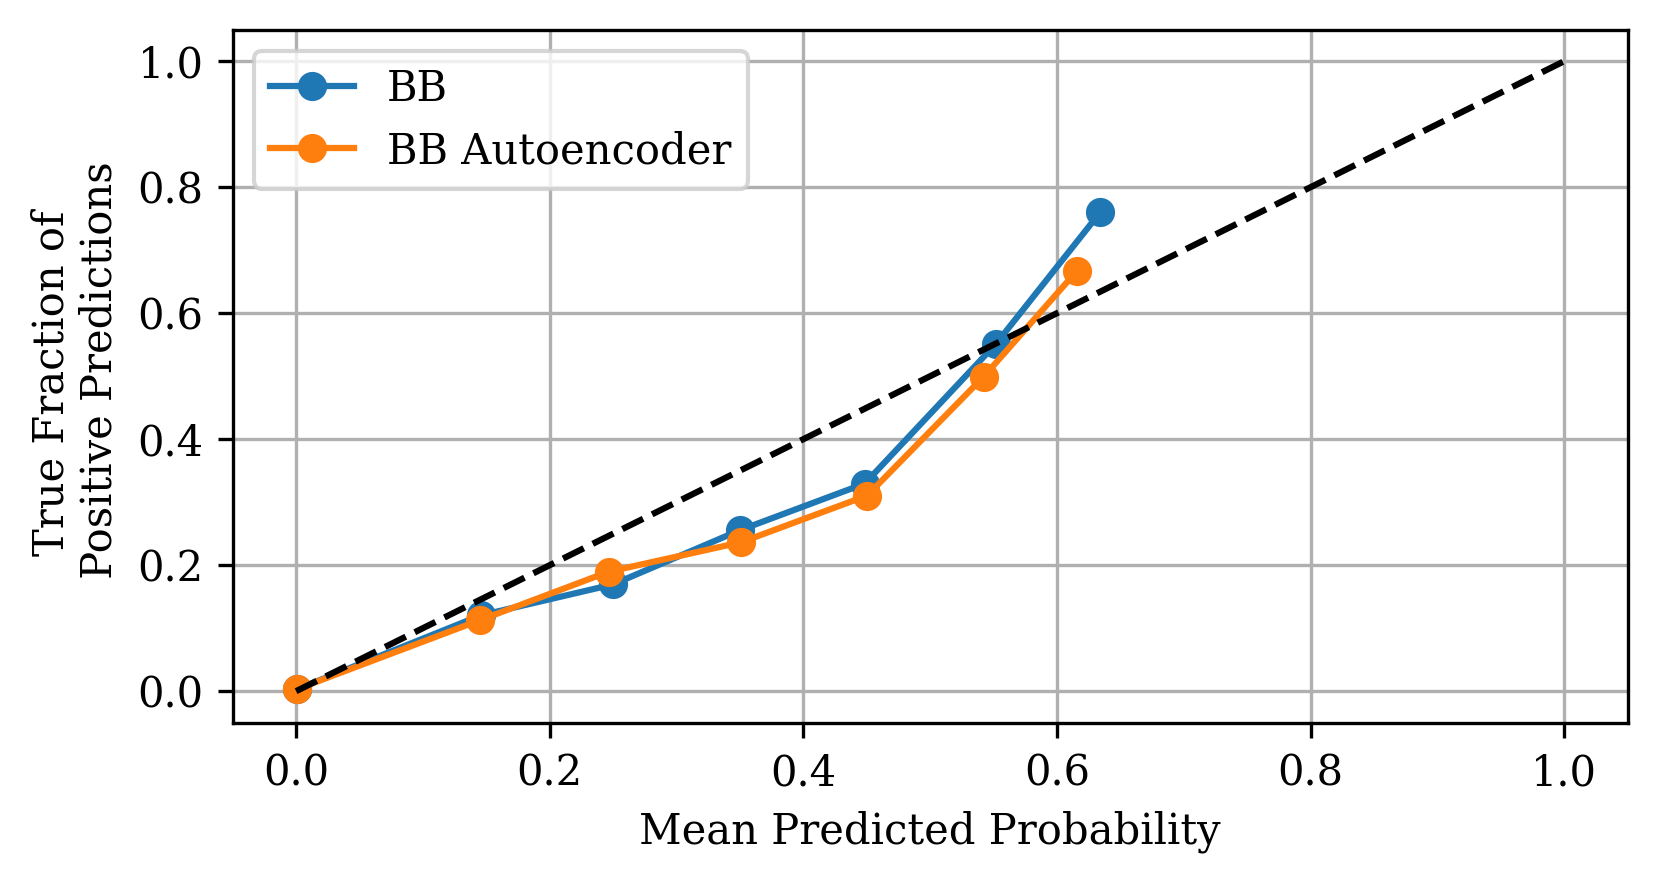

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(prob_pred_bb, prob_true_bb, marker='o', label='BB')
plt.plot(prob_pred_bb_autoencoder, prob_true_bb_autoencoder, marker='o', label='BB Autoencoder')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Fraction of \n Positive Predictions')
plt.title('Reliability Plot')
plt.legend()
plt.grid(True)
plt.show()

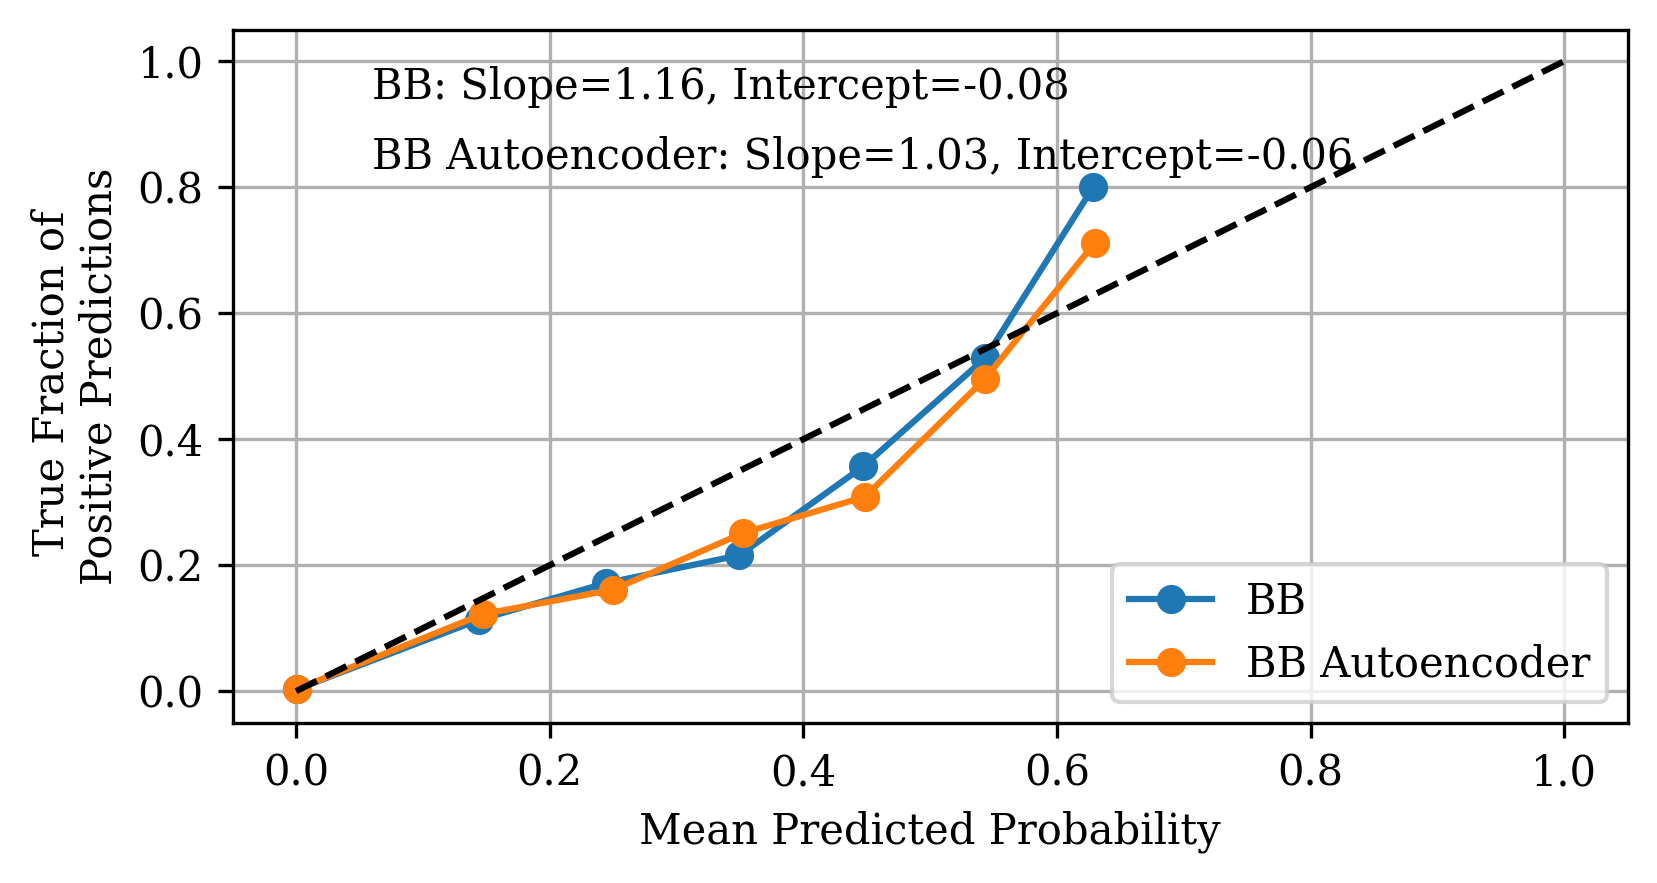

In [30]:
from sklearn.calibration import calibration_curve
import numpy as np

# Calculate reliability curve
prob_true_bb, prob_pred_bb = calibration_curve(y_test, calibrated_bb_preds_proba, n_bins=10, strategy='uniform')
prob_true_bb_autoencoder, prob_pred_bb_autoencoder = calibration_curve(y_test, calibrated_bb_autoencoder_preds_proba, n_bins=10, strategy='uniform')

# Fit a linear regression to obtain the calibration slope and intercept
calibration_slope_bb, calibration_intercept_bb = np.polyfit(prob_pred_bb, prob_true_bb, 1)
calibration_slope_bb_autoencoder, calibration_intercept_bb_autoencoder = np.polyfit(prob_pred_bb_autoencoder, prob_true_bb_autoencoder, 1)

# Plot reliability curve
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(prob_pred_bb, prob_true_bb, marker='o', label='BB')
plt.plot(prob_pred_bb_autoencoder, prob_true_bb_autoencoder, marker='o', label='BB Autoencoder')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Fraction of \nPositive Predictions')
plt.legend(loc='lower right')

# Add calibration slope and intercept to the plot
plt.text(0.1, 0.9, f'BB: Slope={calibration_slope_bb:.2f}, Intercept={calibration_intercept_bb:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'BB Autoencoder: Slope={calibration_slope_bb_autoencoder:.2f}, Intercept={calibration_intercept_bb_autoencoder:.2f}', transform=plt.gca().transAxes)

plt.grid(True)
plt.show()


## **precision-recall vs threshold**

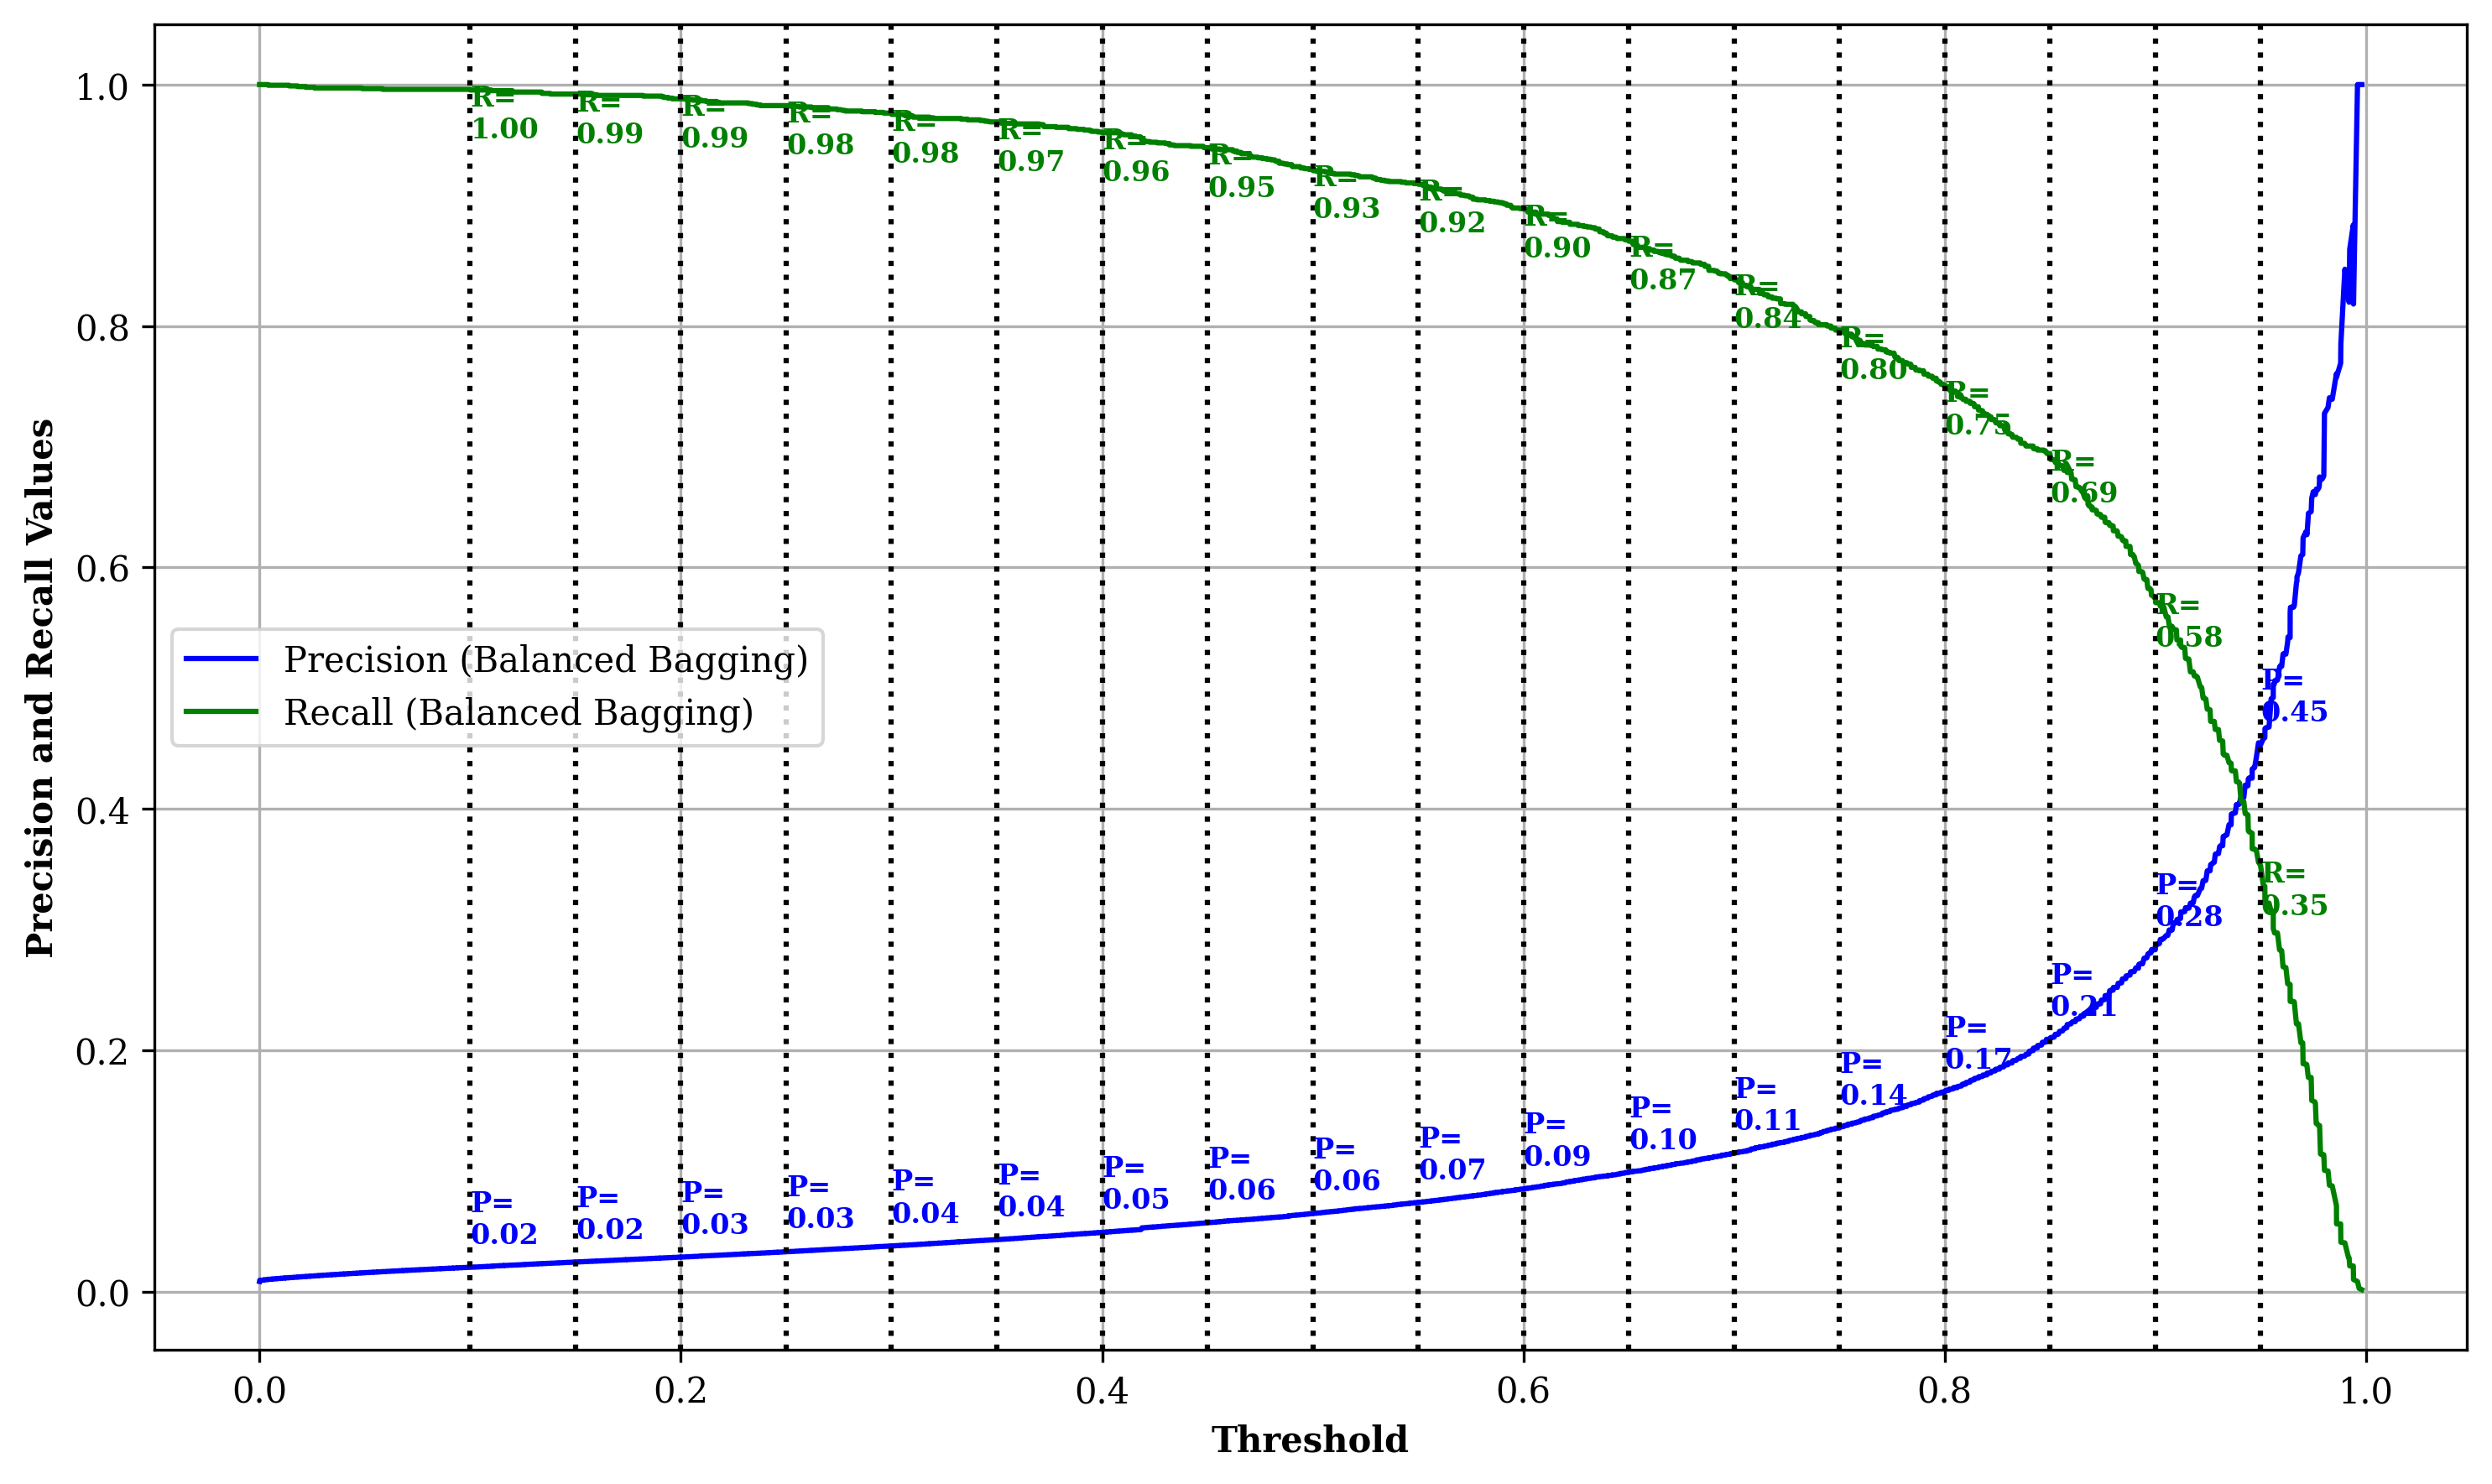

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=300)
# Plot Precision and Recall for Balanced Bagging
plt.plot(threshold_balanced_bagging, precision_balanced_bagging[:-1], 'blue', label='Precision (Balanced Bagging)')
plt.plot(threshold_balanced_bagging, recall_balanced_bagging[:-1], 'green', label='Recall (Balanced Bagging)')

# threshold values to display
threshold_values = [0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Annotate the plot with precision and recall values at each threshold
for threshold in threshold_values:
    index = np.argmin(np.abs(threshold_balanced_bagging - threshold))
    plt.axvline(x=threshold, linestyle=":", color='k')
    plt.text(threshold, precision_balanced_bagging[index] + 0.02, f'P=\n{precision_balanced_bagging[index]:.2f}', fontsize=8, color='blue', fontweight='bold')
    plt.text(threshold, recall_balanced_bagging[index] - 0.04, f'R=\n{recall_balanced_bagging[index]:.2f}', fontsize=8, color='green', fontweight='bold')

plt.xlabel('Threshold', fontweight='bold')
plt.ylabel('Precision and Recall Values', fontweight='bold')
plt.title('Precision and Recall vs Threshold (Balanced Bagging)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **precision-recall curve at 0.5 threshold**

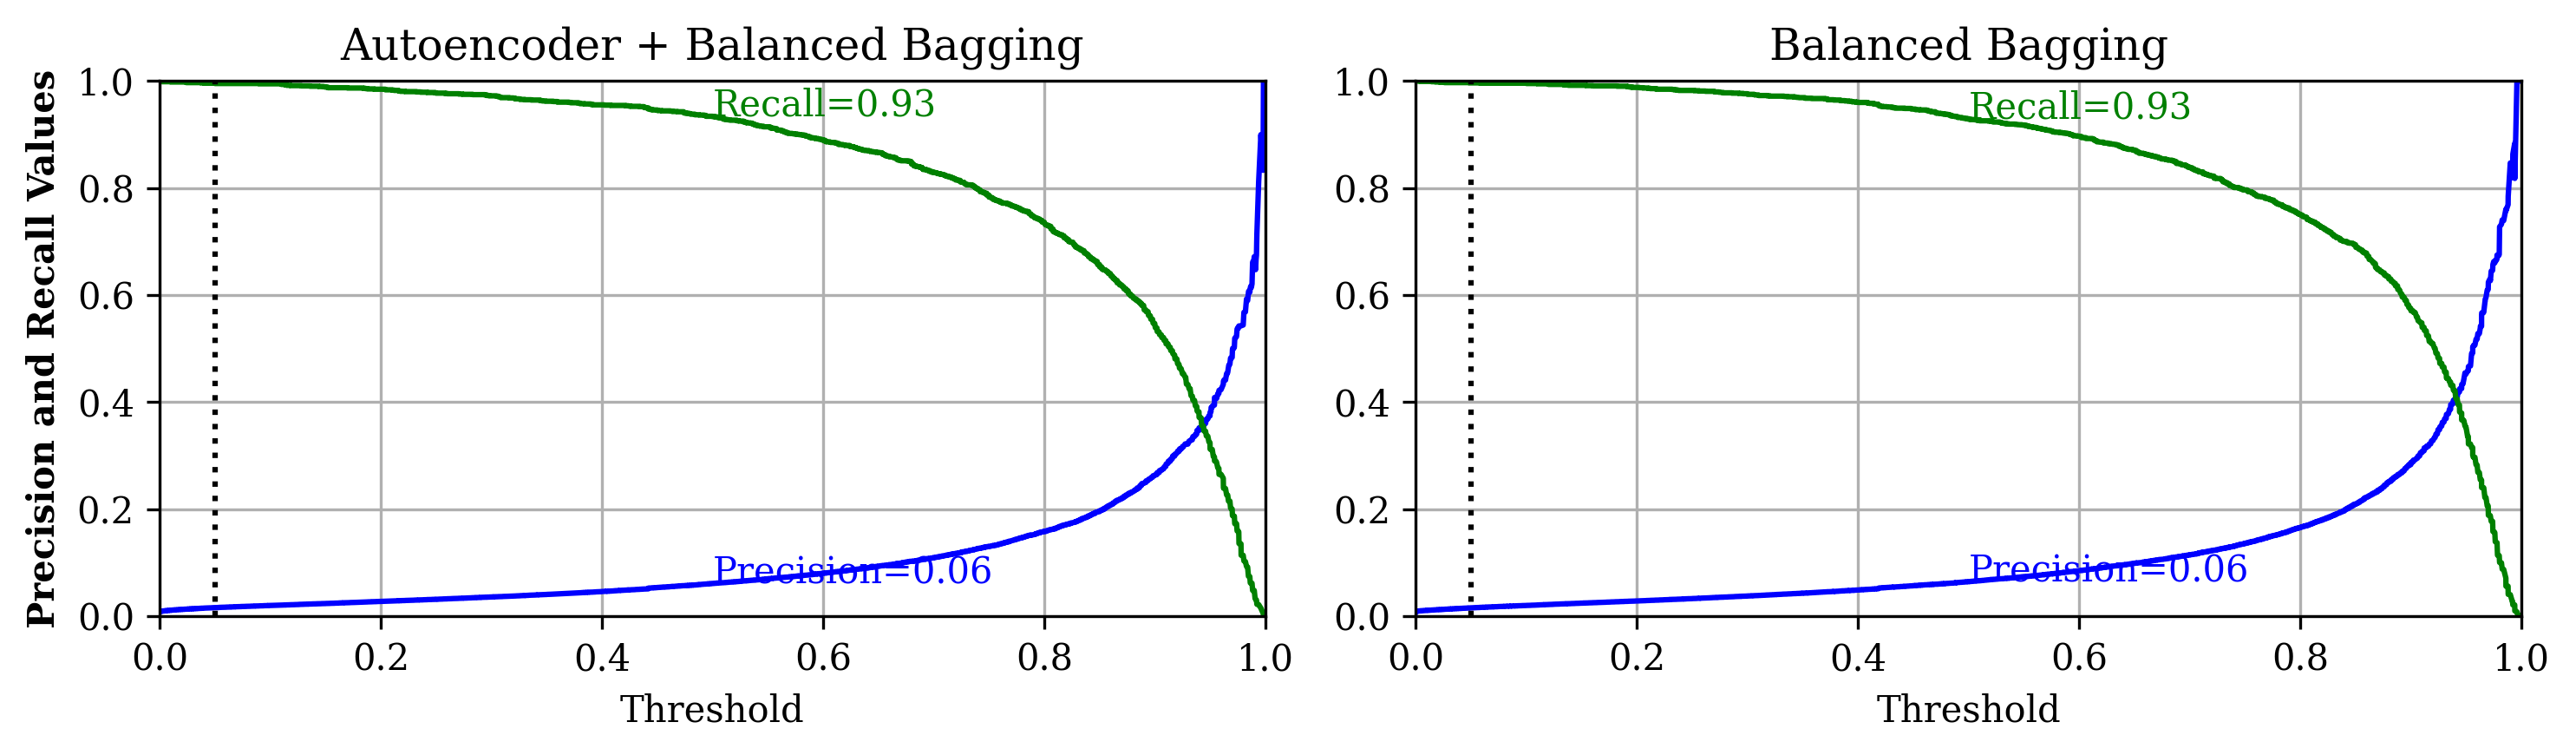

In [ ]:
plt.figure(figsize=(10, 3), dpi=300)  # Set the figure size

# Calculate precision, recall, and corresponding threshold for the model
precision, recall, threshold = precision_recall_curve(y_test, bb_autoencoder_preds_proba)

# Plot Precision and Recall for a given threshold (Left plot)
plt.subplot(1, 2, 1)
plt.plot(threshold, precision[:-1], 'blue', label='Precision')
plt.plot(threshold, recall[:-1], 'green', label='Recall')
plt.axvline(x=.05, linestyle=":", color='k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision and Recall Values', fontweight='bold')
plt.xlabel('Threshold')
plt.title('Autoencoder + Balanced Bagging')
plt.grid()

# Annotate the plot with precision and recall values
threshold_display = 0.5
index = np.argmin(np.abs(threshold - threshold_display))
plt.text(threshold[index], precision[index], f'Precision={precision[index]:.2f}', fontsize=10, color='blue')
plt.text(threshold[index], recall[index], f'Recall={recall[index]:.2f}', fontsize=10, color='green')

# Calculate precision, recall, and corresponding threshold for the model
precision, recall, threshold = precision_recall_curve(y_test, bb_preds_proba)

# Plot Precision and Recall for a given threshold (Right plot)
plt.subplot(1, 2, 2)
plt.plot(threshold, precision[:-1], 'blue', label='Precision')
plt.plot(threshold, recall[:-1], 'green', label='Recall')
plt.axvline(x=.05, linestyle=":", color='k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision and Recall Values')
plt.xlabel('Threshold')
plt.title('Balanced Bagging')
plt.grid()

# Annotate the plot with precision and recall values
threshold_display = 0.5
index = np.argmin(np.abs(threshold - threshold_display))
plt.text(threshold[index], precision[index], f'Precision={precision[index]:.2f}', fontsize=10, color='blue')
plt.text(threshold[index], recall[index], f'Recall={recall[index]:.2f}', fontsize=10, color='green')

plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

y_pred = bb.predict(X_test_log)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

from sklearn.metrics import f1_score
# Calculate macro-average F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro-average F1 Score:", macro_f1)

f2_score = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2_score)

from sklearn.metrics import matthews_corrcoef
mcc_score = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc_score)

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen’s Kappa:", kappa_score)

from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

Confusion Matrix:
[[184138  23797]
 [   125   1655]]
F1 Score: 0.12154817861339601
Macro-average F1 Score: 0.5302767384787999
F2 Score: 0.2540525604813951
Matthews Correlation Coefficient (MCC): 0.2290486073943253
Cohen’s Kappa: 0.10738611577084489
Brier Score: 0.11406909377011659


In [37]:
total_samples = len(y_test)  # Total number of samples

# Calculate percentages for each cell in the confusion matrix
conf_matrix_percent = conf_matrix / total_samples * 100
# Set printing options to display as real numbers with two decimal places
np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})
# Print the confusion matrix with percentages
print("Confusion Matrix (%):")
print(conf_matrix_percent.round(2))

Confusion Matrix (%):
[[87.80 11.35]
 [0.06 0.79]]


# **Performance tuning**

## **number of estmators selection**

In [ ]:
bb = BalancedRandomForestClassifier(n_jobs = -1)
parameters = {
    'n_estimators': [20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.92, 0.95, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}
clf = GridSearchCV(bb, parameters, cv=5, verbose=0, n_jobs=-1).fit(X_train_log, y_train)
plot_grid_search(clf)
table_grid_search(clf)

## **stratified k-fold**

In [ ]:
bb = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(bb, X_train_log, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

## **Profit calculations**

In [ ]:
def calculate_profit(row, costs, revenue):
    inventory_level = row['national_inv'] + row['in_transit_qty']
    backorders = row['went_on_backorder']
    lead_time = row['lead_time']
    potential_issue = row['potential_issue']
    deck_risk = row['deck_risk']

    holding_cost = costs['holding']
    backorder_cost = costs['backorder']
    lead_time_cost = costs['lead_time']
    potential_issue_cost = costs['potential_issue']
    deck_risk_cost = costs['deck_risk']

    if backorders == 0:
        profit = revenue - (holding_cost * inventory_level) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    else:
        profit = revenue - (holding_cost * inventory_level) - (backorder_cost * backorders) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    return profit

# Convert predictions to a DataFrame with the same number of rows as X_test
df_predictions = pd.DataFrame(bb_pred, columns=['went_on_backorder'])

# Create a DataFrame from X_test with the aligned column names
df_X_test = pd.DataFrame(X_test_log, columns=X_test.columns) #, columns=X.columns)

# Concatenate the original DataFrame with the predicted values
df_combined = pd.concat([df_X_test, df_predictions], axis=1)

# Apply the calculate_profit function to each row of the combined DataFrame
costs = {
    'holding': 2,
    'backorder': 50,
    'lead_time': 20,
    'potential_issue': 10,
    'deck_risk': 0.5
}

df_combined['revenue'] = (df_combined['sales_1_month'] + df_combined['sales_3_month'] + df_combined['sales_6_month'] + df_combined['sales_9_month']).sum()
df_combined['went_on_backorder'] = df_combined['went_on_backorder'].astype(int)  # Convert to integer type
df_combined['profit'] = df_combined.apply(lambda row: calculate_profit(row, costs, row['revenue']), axis=1)


# Display the mean profit value
print(df_combined['profit'].mean())


1468433.2882466672


## **Optimization**

In [ ]:
from scipy.optimize import minimize

def objective_function(decision_variables):
    holding_cost = decision_variables[0]
    backorder_cost = decision_variables[1]
    lead_time_cost = decision_variables[2]
    potential_issue_cost = decision_variables[3]
    deck_risk_cost = decision_variables[4]

    # Calculate the total profit using the updated cost values
    df_combined['profit'] = df_combined.apply(lambda row: calculate_profit(row, {
        'holding': holding_cost,
        'backorder': backorder_cost,
        'lead_time': lead_time_cost,
        'potential_issue': potential_issue_cost,
        'deck_risk': deck_risk_cost
    }, row['revenue']), axis=1)

    # Return the negative of the mean profit value (to convert maximization to minimization)
    return -df_combined['profit'].mean()

# Initial guess for the decision variable values
x0 = [2, 5, 1, 0.5, 1]

# Define the constraints
constraints = [
    # Constraint: holding_cost >= 0
    {'type': 'ineq', 'fun': lambda x: x[0]},
    # Constraint: backorder_cost >= 0
    {'type': 'ineq', 'fun': lambda x: x[1]},
    # Constraint: lead_time_cost >= 0
    {'type': 'ineq', 'fun': lambda x: x[2]},
    # Constraint: potential_issue_cost >= 0
    {'type': 'ineq', 'fun': lambda x: x[3]},
    # Constraint: deck_risk_cost >= 0
    {'type': 'ineq', 'fun': lambda x: x[4]}
]


# Perform the optimization to maximize the profit
result = minimize(objective_function, x0, constraints=constraints, method='SLSQP')

# Extract the optimal decision variable values from the optimization result
optimal_decision_variables = result.x

# Calculate the total profit using the optimal cost values
df_combined['profit'] = df_combined.apply(lambda row: calculate_profit(row, {
    'holding': optimal_decision_variables[0],
    'backorder': optimal_decision_variables[1],
    'lead_time': optimal_decision_variables[2],
    'potential_issue': optimal_decision_variables[3],
    'deck_risk': optimal_decision_variables[4]
}, row['revenue']), axis=1)

# Display the optimal profit value
optimal_profit = df_combined['profit'].mean()
print(f"Optimal profit: {optimal_profit}")

Optimal profit: 1468608.3262975542


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, bb_pred)

# Define misclassification costs
false_negative_cost = 100  # Cost of misclassifying a backorder item as non-backorder
false_positive_cost = 10   # Cost of misclassifying a non-backorder item as backorder

# Calculate misclassification costs
misclassification_cost = (cm[1, 0] * false_negative_cost) + (cm[0, 1] * false_positive_cost)

print("Misclassification Cost:", misclassification_cost)

Misclassification Cost: 193180


## **Permutation importance**

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances
result = permutation_importance(bb, X_train_log[:50000], y_train[:50000], n_repeats=10, random_state=42)

# Get sorted indices of importances
sorted_idx = result.importances_mean.argsort()


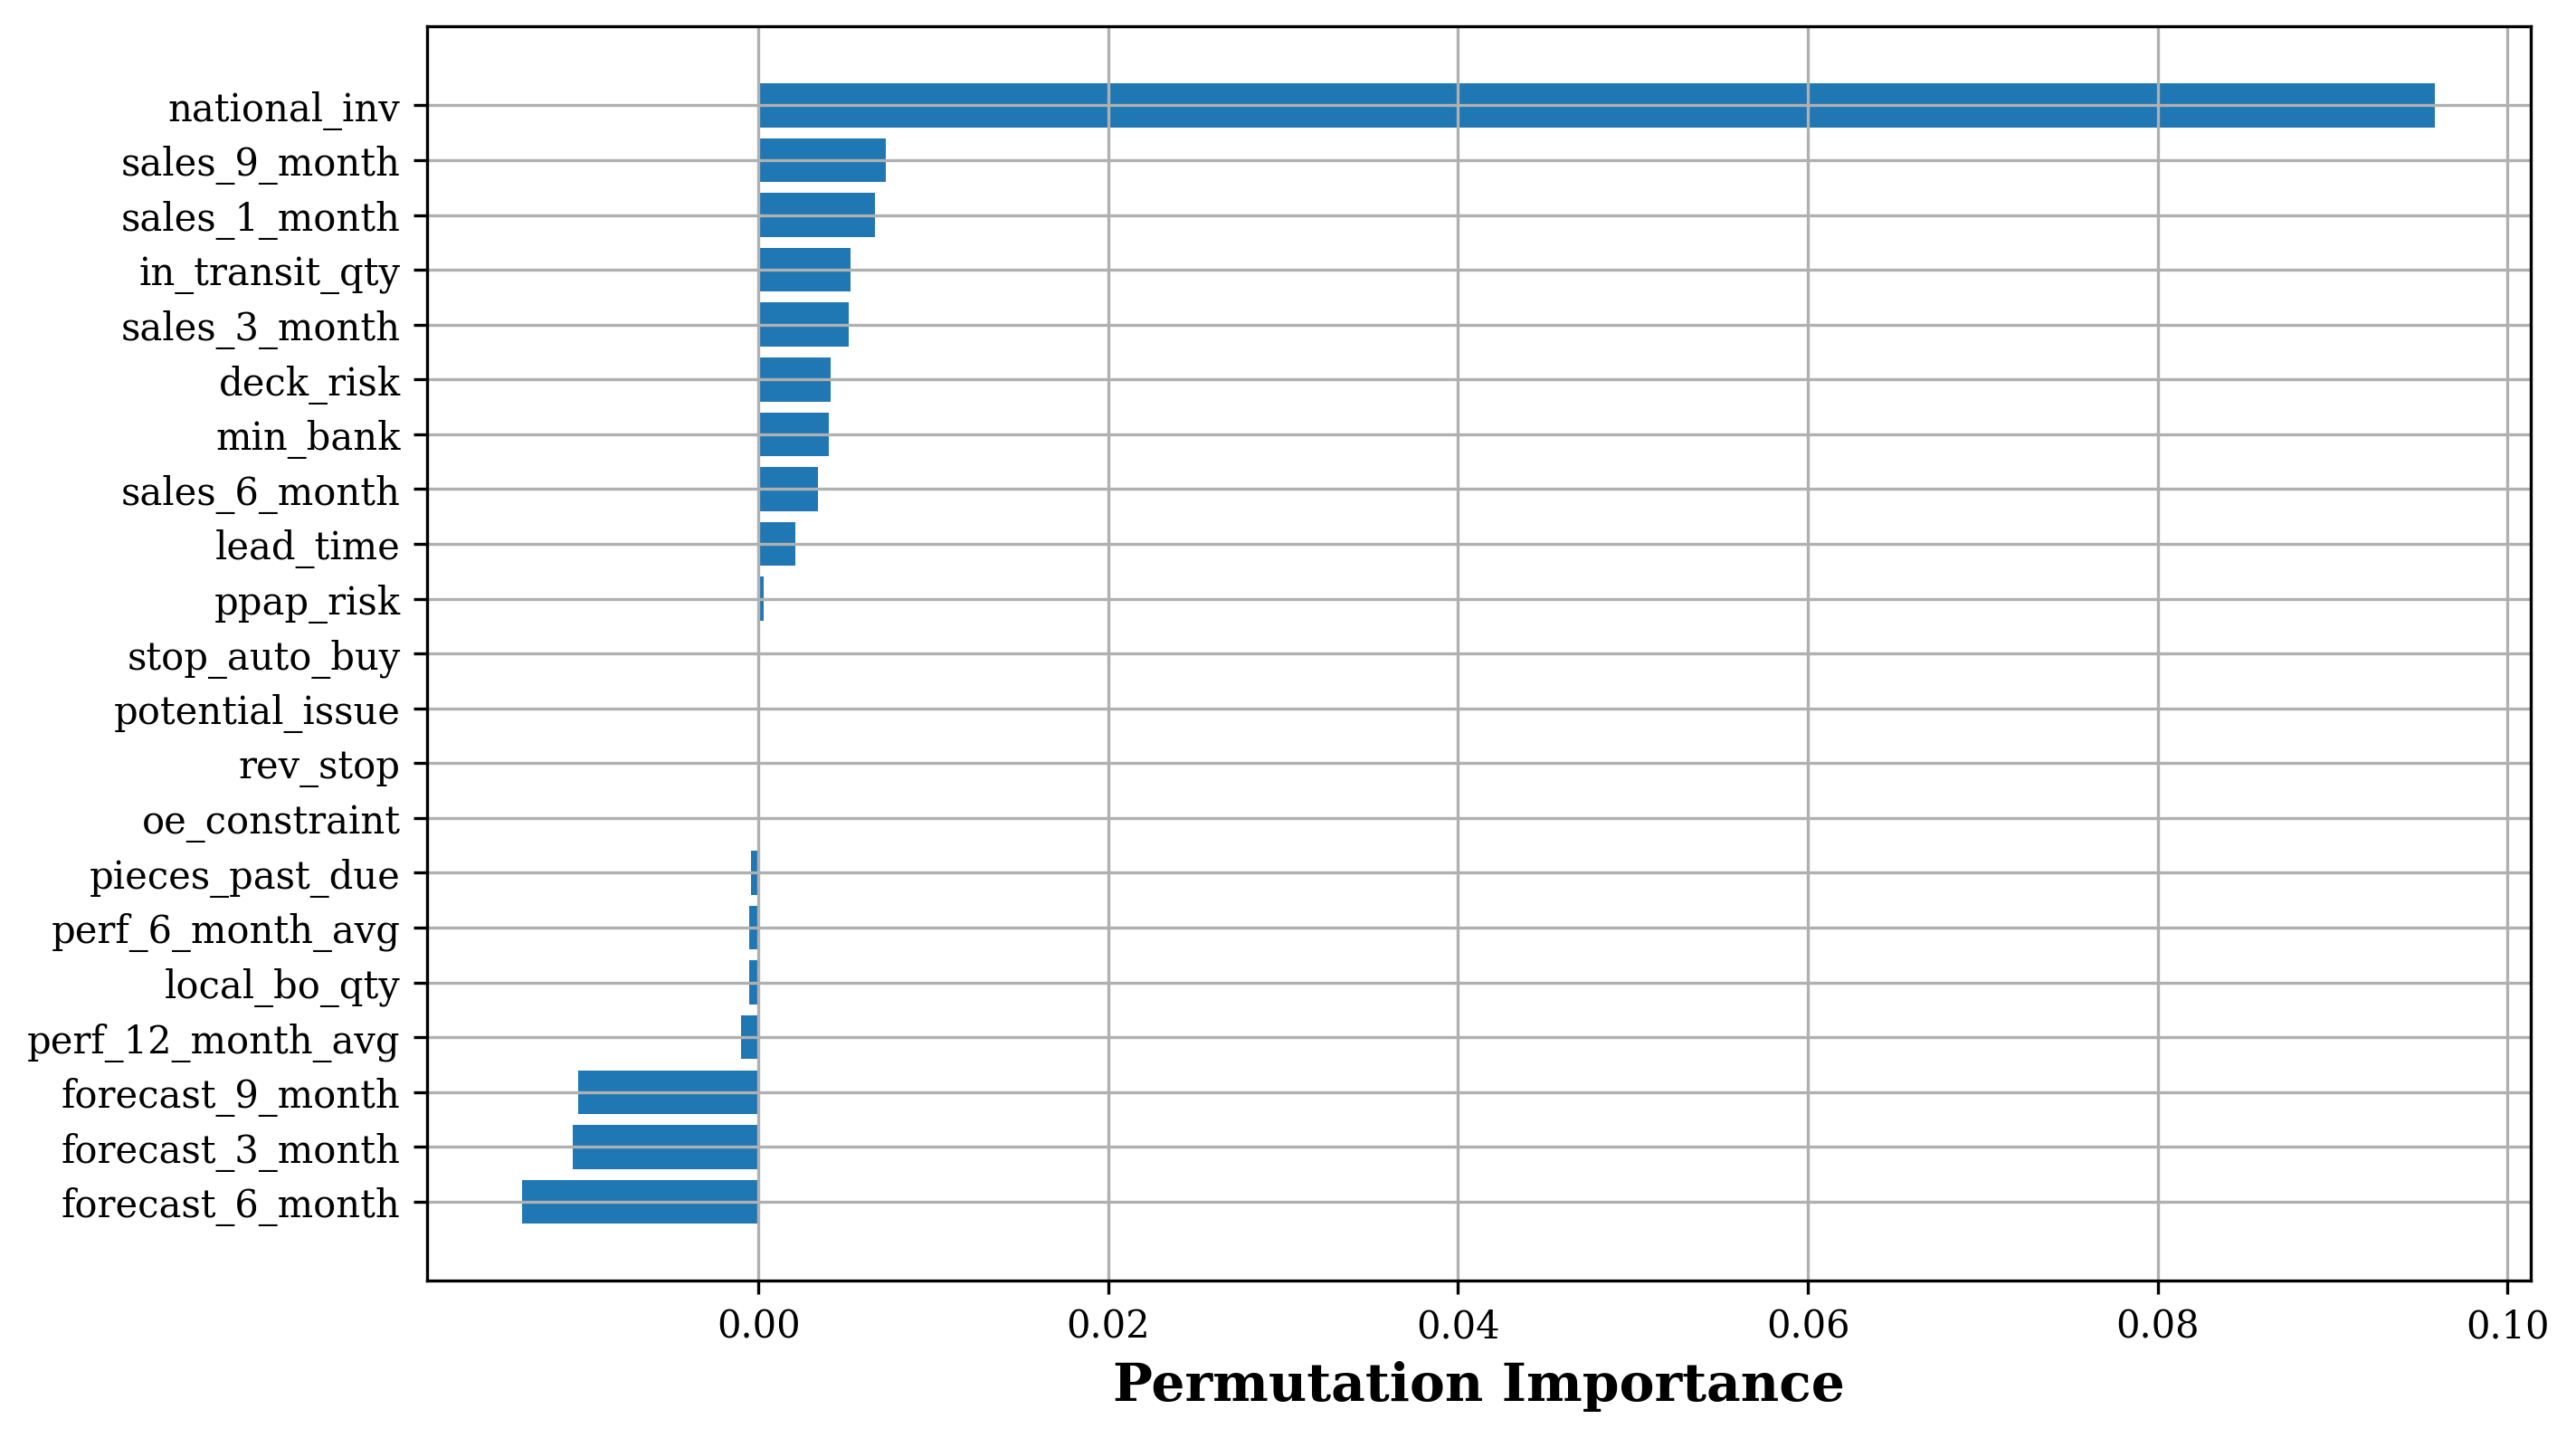

In [19]:
# Plot permutation importances
plt.figure(figsize=(10, 6), dpi=300)
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance', fontsize=14, fontweight='bold')
# plt.title('Permutation Importances (Test set)')
plt.grid()
plt.show()

## **Partial dependence plot**

In [ ]:
PartialDependenceDisplay.from_estimator(bb,
                                   features=y_train[:25000],
                                   X=X_train_log[:25000],
                                   feature_names=X_train.columns)

## **Cost-sensitive learning**
####  Here, we assign a higher cost to misclassifying the minority class (backorder)

In [ ]:
cost_sensitive_rf = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1)
cost_matrix = [[0, 1],  # No backorder (0) correctly classified (0 cost), misclassified as backorder (cost 1)
               [10, 0]]  # Backorder (1) correctly classified (0 cost), misclassified as no backorder (cost 10)

# Custom scoring function using F1 score to account for class imbalance
# make_scorer to create a scorer compatible with GridSearchCV
custom_scoring = make_scorer(f1_score)

# Hyperparameter tuning
param_grid = {
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]
}

grid_search = GridSearchCV(cost_sensitive_rf, param_grid, scoring=custom_scoring, cv=5, n_jobs=-1)
grid_search.fit(X_train_log, y_train)

best_cost_sensitive_rf = grid_search.best_estimator_

# Train the best model on the entire training set
best_cost_sensitive_rf.fit(X_train_log, y_train)
